<a href="https://colab.research.google.com/github/Nagakiran1/Crowd-Counting/blob/main/Testing_CrowdCountingModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Nagakiran1/Crowd-Counting
%cd Crowd-Counting

Cloning into 'Crowd-Counting'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 149 (delta 9), reused 0 (delta 0), pack-reused 124
Receiving objects: 100% (149/149), 23.73 MiB | 36.70 MiB/s, done.
Resolving deltas: 100% (38/38), done.
/content/Crowd-Counting


In [7]:
from keras.models import model_from_json
import numpy as np
from keras import models
import cv2, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Utils import FilterContours,ApplyContours, AdjustContours, FilterImage, Preoprocessimage

# def Preoprocessimage(a, ModeofImage):
#   #a[np.abs(a[:,:,0]-m[:,:,0])<10] = 255
#   a[np.abs(a.sum(2) - ModeofImage.sum(2))<25] = 255
#   kernel = np.ones((2,2),np.uint8)
#   b = cv2.morphologyEx(a, cv2.MORPH_OPEN, kernel)
#   b = cv2.GaussianBlur(b,(3,3),0)
#   return b

def GetNoofPersons(points, row):
  coords = points[((points[:,0]>row['x']) & (points[:,0]<(row['x']+row['w']))) & ((points[:,1]>row['y']) & (points[:,1]<(row['y']+row['h'])))]
  return coords.shape[0]

def GenerateInsideData(activation_model, array, image, points=None, testing=False):
  # Buidling inbetween 6 layer model of trained model
  a = activation_model.predict(array)
  # print(int(model.predict(array)[0][0]), '  -  ', labels[rvalue])

  # Taking Fifthe layer Embeddings to represent the Convolution features of Images
  first_layer_activation = a[5]
  n = first_layer_activation[0, :, :, 0].copy()
  # Applying the Median Blur Image processing technique to reduce Noise of images
  n = cv2.medianBlur(n,3)
  # Applying the Median Blur Image processing technique to reduce Noise of images
  n[n<n.max()/3] = 0
  n = cv2.medianBlur(n,3)

  # Applyint Contours to detected crowd patterns
  df, im1 = ApplyContours(n.copy())

  # Adjusting the multiple contours and the area wise dilation of contours from Camera angle
  df, im2, ImSegments = AdjustContours(df, image.copy())

  # Filter and zero padding the images to apply on the Crowd Counting model
  CrowdGroups  = np.concatenate([FilterImage(word)[np.newaxis] for word in ImSegments])
  if testing:
    return df, CrowdGroups,n,im2

  # Assigning Number of persons associated with the each Cluster cropped
  df['NoofPersons'] = df.apply(lambda x: GetNoofPersons(points, x), 1)

  #df['Images'] = CrowdGroups
  return df, CrowdGroups


def PlotGroups(im1, df1, font=0.7):
  for ind, row in df1.iterrows():
      x,y,w,h = row[['x','y','w','h']].astype(int).values
      cv2.rectangle(im1,(x,y),(x+w,y+h),(0,255,0),2)
      cv2.putText(im1, 'group size - '+ str(int(row['NoofPersons'])), 
                  (x,y+20),  cv2.FONT_HERSHEY_SIMPLEX , font, (255, 0, 0), 2, cv2.LINE_AA) 
  return im1


def ReadData():
    if not os.path.exists('images.npy'):
        ims = []
        for file in os.listdir('data'):
            im = cv2.imread(os.path.join('data',file))
            ims.append(im[np.newaxis])
    else:
        img = np.load('images.npy')
    img = np.concatenate(ims)
    return img

def LoadModels():
    # load json and create model
    json_file = open('Models/model1.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    GroupModel = model_from_json(loaded_model_json)
    # load weights into new model
    GroupModel.load_weights("Models/model1.h5")
    print("Loaded model from disk")
     
            
    # load json and create model
    json_file = open('Models/PersonModel.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    PersonModel = model_from_json(loaded_model_json)
    # load weights into new model
    PersonModel.load_weights("Models/PersonModel.h5")
    print("Loaded model from disk")
    
    # Extracts the outputs of the top 12 layers
    layer_outputs = [layer.output for layer in  GroupModel.layers[:12]] 
    # Creates a model that will return these outputs, given the model input
    activation_model = models.Model(inputs=GroupModel.input, outputs=layer_outputs) 
    
    return GroupModel, PersonModel, activation_model



In [4]:

ModeofImage = np.load('ModeOfImage.npy')

img = ReadData()
GroupModel, PersonModel, activation_model = LoadModels()


Loaded model from disk
Loaded model from disk


In [5]:
rvalue = np.random.randint(50)
image = img[rvalue]


array = Preoprocessimage(image.copy(), ModeofImage)[None,:]

df, CG, n, im2 = GenerateInsideData(activation_model, array, image.copy(), testing=True)

df['NoofPersons'] = PersonModel.predict(CG).flatten()
df1 = df.loc[df['NoofPersons']>3]
im1 = image.copy()
im1 = PlotGroups(im1, df1, font=0.8)

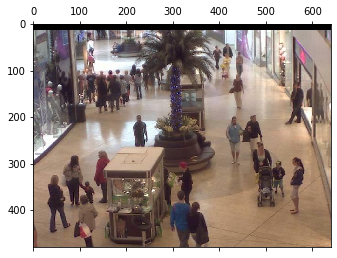

In [8]:
plt.matshow(image, cmap='viridis')

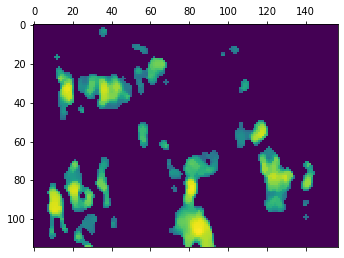

In [11]:
plt.matshow(n, cmap='viridis')

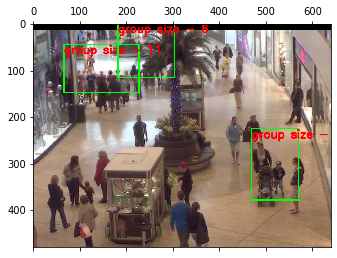

In [10]:
plt.matshow(im1, cmap='viridis')